# VAE for SMBA

This VAE is adapted from the GM-VAE implementation.

In [114]:
%reload_ext autoreload
%autoreload 2

In [115]:
num_epochs=10000

## Import Libraries

In [116]:
import json

import numpy as np
import argparse
import random
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from cma import CMAEvolutionStrategy

import warnings
warnings.filterwarnings('ignore')

import sys

pathfinder_dir = '/home/yangz2/projects/1906-pcgml/pcgml-gmmVae-exp/demos/anurag_pathfinder_smba'
sys.path.append(pathfinder_dir)
import test_level_smb as astar

sys.path.append('../pytorch')
from model.VAE_kld_loss_v2 import *

sys.path.append('../../1906-pcgml/pcgml-gmmVae-exp/modules/')
import vglc_with_path_encodings

## Load data

In [117]:
def open_json_as_nparray(json_fname):
    with open(json_fname, 'r') as json_f:
        return np.array(json.load(json_f))

Load SMB.

In [118]:
smb_int = open_json_as_nparray('smbWithPath-allLevels-chunks-int.json')

In [9]:
smb_onehot = np.eye(len(np.unique(smb_int)))[smb_int]
smb_onehot.shape

(2698, 16, 16, 12)

In [10]:
smb_onehot = smb_onehot.reshape(
    smb_onehot.shape[0], 
    smb_onehot.shape[1] * smb_onehot.shape[2] * smb_onehot.shape[3]
)
smb_onehot.shape

(2698, 3072)

In [11]:
chunks = smb_onehot

## Input Parameters

In [12]:
########################################################
## Input Parameters
#########################################################
parser = argparse.ArgumentParser(description='PyTorch Implementation of DGM Clustering')

## Used only in notebooks
parser.add_argument('-f', '--file',
                    help='Path for input file. First line should contain number of lines to search in')

## Dataset
parser.add_argument('--dataset', type=str, choices=['mnist'],
                    default='mnist', help='dataset (default: mnist)')
parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')

## GPU
parser.add_argument('--cuda', type=int, default=0,
                    help='use of cuda (default: 1)')
parser.add_argument('--gpuID', type=int, default=0,
                    help='set gpu id to use (default: 0)')

## Training
parser.add_argument('--epochs', type=int, default=num_epochs,
                    help='number of total epochs to run (default: 200)')
parser.add_argument('--batch_size', default=64, type=int,
                    help='mini-batch size (default: 64)')
parser.add_argument('--batch_size_val', default=200, type=int,
                    help='mini-batch size of validation (default: 200)')
parser.add_argument('--learning_rate', default=1e-3, type=float,
                    help='learning rate (default: 0.001)')
parser.add_argument('--decay_epoch', default=-1, type=int, 
                    help='Reduces the learning rate every decay_epoch')
parser.add_argument('--lr_decay', default=0.5, type=float,
                    help='Learning rate decay for training (default: 0.5)')

## Architecture
parser.add_argument('--gaussian_size', default=64, type=int,
                    help='gaussian size (default: 64)')
parser.add_argument('--input_size', default=3072, type=int,
                    help='input size (default: 784)')  # edited for this task

## Partition parameters
parser.add_argument('--train_proportion', default=0.9, type=float,
                    help='proportion of examples to consider for training only (default: 1.0)')

## Loss function parameters
parser.add_argument('--w_gauss', default=2, type=float,
                    help='weight of gaussian loss (default: 1)')
parser.add_argument('--w_categ', default=1, type=float,
                    help='weight of categorical loss (default: 1)')
parser.add_argument('--w_rec', default=1, type=float,
                    help='weight of reconstruction loss (default: 1)')
parser.add_argument('--rec_type', type=str, choices=['bce', 'mse'],
                    default='bce', help='desired reconstruction loss function (default: bce)')

## Others
parser.add_argument('--verbose', default=0, type=int,
                    help='print extra information at every epoch.(default: 0)')

args = parser.parse_args()

Set random seed in case it was specified in the parameters


In [13]:
## Random Seed
SEED = args.seed
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if args.cuda:
    torch.cuda.manual_seed(SEED)

## Data Partition

We split the training data into train and validation according to the *train_proportion* parameter:

In [14]:
from torch.utils.data import TensorDataset, DataLoader

In [15]:
assert args.train_proportion != 1

In [16]:
def partition_dataset(n, proportion=0.9):
   train_num = int(n * proportion)
   indices = np.random.permutation(n)
   train_indices, val_indices = indices[:train_num], indices[train_num:]
   return train_indices, val_indices

train_indices, val_indices = partition_dataset(len(chunks), args.train_proportion)
train_ds = TensorDataset(torch.from_numpy(chunks).float())
train_dl = DataLoader(train_ds, batch_size=args.batch_size, sampler=SubsetRandomSampler(train_indices))
valid_dl = DataLoader(train_ds, batch_size=args.batch_size_val, sampler=SubsetRandomSampler(val_indices))

## Train Model

In [17]:
# Model Initialization
vae = VAE(args)

In [15]:
# history_loss = vae.train(train_dl, valid_dl)

In [16]:
# torch.save(vae.network.state_dict(), f'smba_vae_kld_loss_v2_{num_epochs}.pth')

In [18]:
vae.network.load_state_dict(torch.load(f'smba_vae_kld_loss_v2_{num_epochs}.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

## Image Reconstruction

In [20]:
original, reconstructed = vae.reconstruct_data(train_dl, len(train_ds))  

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
original_int = original.reshape(len(train_ds), 16, 16, 12).argmax(axis=-1)
reconstructed_int = reconstructed.reshape(len(train_ds), 16, 16, 12).argmax(axis=-1)

In [ ]:
np.sum(original_int != reconstructed_int) / len(train_ds)

In [ ]:
def get_classes(chunks_int):
    classes = []
    for i in chunks_int:
        if i.max() == 6:
            classes.append('kia')
        else:
            classes.append('smba')
    return np.array(classes)

In [ ]:
org_classes = get_classes(original_int)
rec_classes = get_classes(reconstructed_int)
assert np.sum(org_classes == rec_classes) == len(org_classes)

In [ ]:
def get_images(chunks_int):
    images = []
    for game, chunk in zip(get_classes(chunks_int), chunks_int):
        images.append(vglc_with_path_encodings.array_to_image([chunk], game=game)[0])
    return images

In [ ]:
org_images = get_images(original_int)
rec_images = get_images(reconstructed_int)
len(org_images), len(rec_images)

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(24, 8))
axes = axes.flatten()
nrows, ncols = 3, 10

org_idxs = np.arange(0, 29, 2)
rec_idxs = org_idxs + 1

for idx in org_idxs:
        
    ax = axes[idx]

    ax.imshow(np.asarray(org_images[idx // 2]))
    ax.set_title(f'Org {idx // 2 + 1}')
    
    ax.axis('off')

for idx in rec_idxs:
        
    ax = axes[idx]

    ax.imshow(np.asarray(rec_images[idx // 2]))
    ax.set_title(f'Rec {idx // 2 + 1}')

    ax.axis('off')
    
plt.show()

## Random Generation per Category

In [ ]:
def display_random_generation(generated, num_classes, n=10):
    plt.figure(figsize=[24,5])
    for c in range(num_classes):
        for i in range(n):
            plt.subplot(num_classes, n, (c * n) + i + 1)
            chunk_int = generated[(c * n) + i].reshape(16, 16, 12).argmax(axis=-1)
            chunk_pix = vglc_with_path_encodings.array_to_image([chunk_int], game='smba')[0]
            plt.imshow(chunk_pix)
            plt.gray()
            plt.axis('off')
    plt.show()

elem_per_category = 15
generated = gmvae.random_generation(elem_per_category)
display_random_generation(generated, args.num_classes, elem_per_category)

In [ ]:
generated = vae.random_generation(10000)
generated.shape

In [ ]:
generated_int = generated.reshape(-1, 16, 16, 12).argmax(axis=-1)

In [ ]:
generated_int.shape

In [ ]:
# since this code chunk depends on random seed, it shouldn't be run again
with open(f'../smba_generations/smba_vae_kld_loss_v2_{num_epochs}.json', 'w+') as json_f:
    json.dump(generated_int.tolist(), json_f)

## Visualization of latent space

In [19]:
from sklearn.decomposition import PCA

In [35]:
pca_variance_kept = 0.90

In [88]:
np.unique(level_idxs)

array([0, 1, 2])

In [93]:
features = vae.latent_features(DataLoader(train_ds, batch_size=128, shuffle=False))
type1 = np.where(level_idxs == 0)[0]
type2 = np.where(level_idxs == 1)[0]
type3 = np.where(level_idxs == 2)[0]

np.random.seed(30)
random_idxs_1 = np.random.choice(type1, size=333, replace=True)
random_idxs_2 = np.random.choice(type2, size=333, replace=True)
random_idxs_3 = np.random.choice(type3, size=333, replace=True)
random_idxs = np.concatenate([random_idxs_1, random_idxs_2, random_idxs_3])

features_for_pca = features[random_idxs].copy()
features_for_pca -= features_for_pca.mean(axis=0)
features_for_pca /= features_for_pca.std(axis=0)
pca_features = PCA(pca_variance_kept).fit_transform(features_for_pca[:1000])
print(pca_features.shape)

(999, 6)


In [94]:
def get_kmeans_labels(X, num_clusters):
    from sklearn.cluster import KMeans
    distances_to_centroids = KMeans(n_clusters=num_clusters, n_init=20).fit_transform(X)
    predicted_labels = distances_to_centroids.argmin(axis=1)
    return distances_to_centroids, predicted_labels

In [95]:
from tqdm import tqdm_notebook
num_clusters_range = np.arange(1, 21)
costs = []
for num_clusters in tqdm_notebook(num_clusters_range, leave=False):
    distances_to_centroids, predicted_labels = get_kmeans_labels(pca_features, num_clusters)
    distances_to_closest_centroids = distances_to_centroids[np.arange(len(pca_features)), predicted_labels]
    costs.append(np.sum(distances_to_closest_centroids))

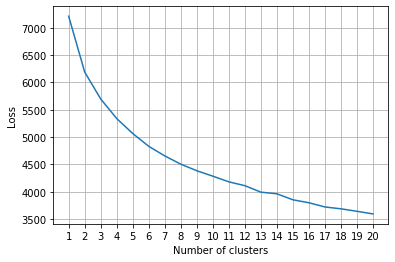

In [96]:
plt.plot(num_clusters_range, costs)
plt.xticks(num_clusters_range)
# plt.title(f'K-means elbow plot for SMB latent vectors (PCA {int(pca_variance_kept * 100)}%)')
plt.xlabel('Number of clusters'); plt.ylabel('Loss')
plt.grid()
plt.savefig(f'K-means elbow plot for SMB latent vectors (PCA {int(pca_variance_kept * 100)}%).png', dpi=100)

In [97]:
from sklearn.manifold import TSNE

np.random.seed(30)
tsne_features = TSNE(n_components=2).fit_transform(features[random_idxs])

In [98]:
kmeans_labels = get_kmeans_labels(pca_features, num_clusters=3)[1]

In [99]:
with open('../../1906-pcgml/pcgml-gmmVae-exp/data/smba_level_idx_per_chunk.json', 'r') as json_f:
    level_idxs = np.array(json.load(json_f))

In [100]:
level_idxs_sub = level_idxs[random_idxs]
print(np.bincount(level_idxs) / len(level_idxs))
print(np.bincount(level_idxs_sub) / len(level_idxs_sub))

[0.11675315 0.67790956 0.20533729]
[0.33333333 0.33333333 0.33333333]


In [101]:
X, Y = np.s_[:,0], np.s_[:,1]

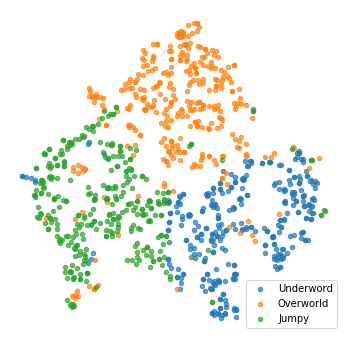

In [102]:
fig = plt.figure(figsize=(6, 6))

labels = ['Underword', 'Overworld', 'Jumpy']
colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c']

for i in range(3):
    plt.scatter(
        tsne_features[level_idxs_sub == i][X], 
        tsne_features[level_idxs_sub == i][Y],
        label=labels[i],
        s=20, alpha=0.7, color=colors[i]
    )

# plt.title('SMB latent vectors color-coded by level-type label')

plt.axis('off')
plt.legend(loc='lower right')
plt.savefig('SMB latent vectors (VAE) color-coded by level type label.png', dpi=100)
plt.show()

### K-means

0.6466466466466466


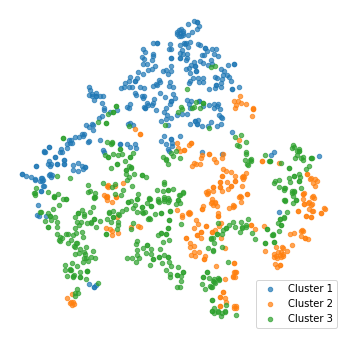

In [103]:
from metrics.Metrics import *
metrics = Metrics()
acc = metrics.cluster_acc(level_idxs_sub, kmeans_labels)
print(acc)

fig = plt.figure(figsize=(6, 6))

colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c']

for i in range(3):
    plt.scatter(
        tsne_features[kmeans_labels == i][X], 
        tsne_features[kmeans_labels == i][Y],
        label=f'Cluster {i+1}',
        s=20, alpha=0.7, color=colors[i]
    )

# plt.title(f'SMB latent vectors color-coded by K-means cluster index (PCA {int(pca_variance_kept * 100)}%)\nClustering accuracy: {round(acc * 100, 1)}%')

plt.axis('off')
plt.legend(loc='lower right')
plt.savefig(f'SMB latent vectors (VAE) color-coded by K-means cluster index (PCA {int(pca_variance_kept * 100)}) Clustering accuracy: {round(acc * 100, 1)}.png', dpi=100)
plt.show()

### GMM

In [104]:
from sklearn.mixture import GaussianMixture

In [105]:
bics = []
for i in tqdm_notebook(np.arange(1, 21)):
    gmm = GaussianMixture(n_components=i, covariance_type='full', n_init=20).fit(pca_features)
    bics.append(gmm.bic(pca_features))

In [ ]:
# save and load the bics

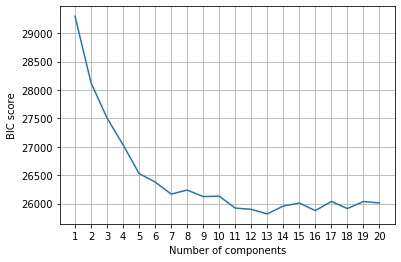

In [113]:
plt.plot(np.arange(1, 21), bics)
plt.xticks(np.arange(1, 21))
plt.xlabel('Number of components'); plt.ylabel('BIC score')
plt.grid()
plt.savefig(f'BIC plot for SMB latent vectors (PCA {int(pca_variance_kept * 100)}%).png', dpi=100)

In [109]:
gmm_labels = GaussianMixture(n_components=3, covariance_type='full', n_init=20).fit_predict(pca_features)

0.5865865865865866


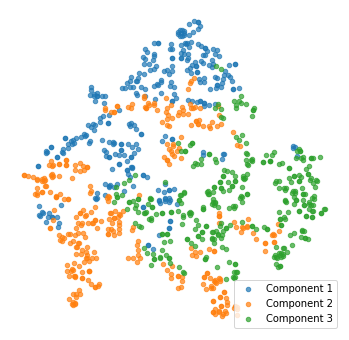

In [110]:
fig = plt.figure(figsize=(6, 6))

acc = metrics.cluster_acc(level_idxs_sub, gmm_labels)
print(acc)

for i in range(3):
    plt.scatter(
        tsne_features[gmm_labels == i][X], 
        tsne_features[gmm_labels == i][Y],
        label=f'Component {i+1}',
        s=20, alpha=0.7
    )

# plt.title(f'SMB latent vectors color-coded by GMM component index (PCA {int(pca_variance_kept * 100)}%)\nClustering accuracy: {round(acc * 100, 1)}%')

plt.axis('off')
plt.legend(loc='lower right')
plt.savefig(f'SMB latent vectors (VAE) color-coded by GMM component index (PCA {int(pca_variance_kept * 100)}) Clustering accuracy: {round(acc * 100, 1)}.png', dpi=100)
plt.show()

## Latent space evolution

In [72]:
char2int_smb = { 
    "X": 0,  # smb unpassable
    "S": 1,  # smb breakable
    "-": 2,  # smb background
    "?": 3,  # smb question
    "Q": 4,  # smb question
    "E": 5,
    "<": 6,
    ">": 7,
    "[": 8,
    "]": 9,
    "o": 10,
    "P": 11,  # for smb path (from Anurag's email)
}
int2char_smba = {v:k for k, v in char2int_smb.items()}

In [24]:
def chunk_int_to_chunk_char(chunk_int):
    chunk_char = []
    for row in chunk_int:
        row_char = []
        for entry in row:
            row_char.append(int2char_smba[int(entry)])
        row_char = ''.join(row_char)
        chunk_char.append(row_char)
    return chunk_char

In [25]:
def get_starting_tile(chunk:np.array)->tuple:
    
    """
    Return the starting point of mario given a chunk.
    :param chunk: an 16-by-16 numpy array of integers
    :return a tuple describing a possible starting point of mario in the chunk (col_idx, row_idx)
    """
    
    for col_idx in range(chunk.shape[1]):  # loop over the columns of the chunk
        col = chunk[:, col_idx]
        
        # if 5 columns have been searched and no appropriate starting points have
        # been found, consider the chunk as unplayable
        # (need more thoughts on how to deal with such cases)
        if col_idx == 5: return None
        
        for row_idx, entry in enumerate(col):  # loop over the entries of the column, from top to bottom
            if entry in [0, 1, 3, 4, 6, 7, 8, 9]:  # tiles on which mario can stand (see above for meaning)
                # the pathfinding code works with starting points of the format (col_idx, row_idx)
                return col_idx, row_idx - 1  # set mario's starting point to be above that tile

In [221]:
with open(f'{pathfinder_dir}/SMB.json') as data_file:    
    platformerDescription = json.load(data_file)

In [222]:
def get_path_from_chunk(chunk:list, chunk_int:np.array, debug=False)->np.array:
    
    # chunk must be in the format of a list of strings
    # chunk is used for pathfinding
    
    try:
        # the following line will fail if no path exist
        starting_tile = get_starting_tile(chunk_int)
        if debug: print(starting_tile)
        
        paths = astar.findPaths(
            10, 
            platformerDescription['solid'], 
            platformerDescription['jumps'], 
            chunk, 
            src=starting_tile
        )[0]
        if debug: print(paths)
    
    except:
        # if no path exist, None will be returned
        return None

    output = np.zeros((16, 16))
    for p in paths:
        output[p[1], p[0]] = 1
    
    return output

In [223]:
def get_chunk_int_from_latent_vec(vec):
    latent_vec = torch.Tensor(vec).reshape(1, 64)
    chunk_int = vae.network.generative(latent_vec)['x_rec'].squeeze().detach().numpy().reshape(16, 16, 12).argmax(-1)
    return chunk_int

In [254]:
def get_path_scoring_func(ideal_path:np.array):
    def path_scoring_func(vec):
        
        latent_vec = torch.Tensor(vec).reshape(1, 64)
        chunk_int = vae.network.generative(latent_vec)['x_rec'].squeeze().detach().numpy().reshape(16, 16, 12).argmax(-1)
        chunk_int[chunk_int == 11] = 2
        chunk_char = chunk_int_to_chunk_char(chunk_int)

        try:
            generated_path = get_path_from_chunk(chunk_char, chunk_int)
            score = np.mean(np.abs((generated_path.argmax(axis=0) - ideal_path.argmax(axis=0))))
            return score
        except:
            return 1000000
    
    return path_scoring_func

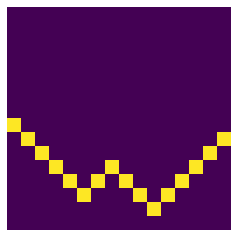

In [255]:
ideal_path = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
])
plt.matshow(ideal_path); plt.axis('off')
plt.show()

In [256]:
path_scoring_func = get_path_scoring_func(ideal_path)

In [257]:
res = CMAEvolutionStrategy(list(np.random.normal(size=64)), 10).optimize(path_scoring_func).result

(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 64 (seed=795636, Mon May  4 20:58:07 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 1.312500000000000e+00 1.0e+00 9.48e+00  9e+00  9e+00 0:00.2
    2     32 1.437500000000000e+00 1.0e+00 9.12e+00  9e+00  9e+00 0:00.4
    3     48 1.125000000000000e+00 1.0e+00 8.84e+00  9e+00  9e+00 0:00.6
   18    288 9.375000000000000e-01 1.1e+00 7.60e+00  8e+00  8e+00 0:03.8
   36    576 8.125000000000000e-01 1.3e+00 6.91e+00  7e+00  7e+00 0:07.9
   58    928 7.500000000000000e-01 1.3e+00 6.80e+00  6e+00  7e+00 0:12.9
   85   1360 6.875000000000000e-01 1.5e+00 6.37e+00  6e+00  7e+00 0:19.1
  100   1600 6.250000000000000e-01 1.5e+00 6.42e+00  6e+00  7e+00 0:22.6
  135   2160 6.250000000000000e-01 1.7e+00 7.13e+00  6e+00  8e+00 0:30.8
  174   2784 6.875000000000000e-01 1.8e+00 6.61e+00  6e+00  7e+00 0:39.9
  200   3200 6.250000000000000e-01 1.8e+00 5.92e+00  5e+00  7e+00 0:45.6
  252   4032 6.250000000000000e-0

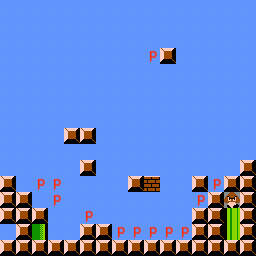

In [259]:
vglc_with_path_encodings.array_to_image([get_chunk_int_from_latent_vec(res[0])], game='smba')[0]

In [260]:
new_chunk = get_chunk_int_from_latent_vec(res[0])
new_chunk[new_chunk == 11] = 2
get_path_from_chunk(chunk_int_to_chunk_char(new_chunk), new_chunk)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.,

In [226]:
chunk_int_to_chunk_char(new_chunk)

['----------------',
 '----------------',
 '----------------',
 '----------------',
 'SSSSSSSSSSSSSSSS',
 '---------------S',
 '-------------SSS',
 '----------------',
 '----------------',
 '----------------',
 '----------------',
 '-------------X-S',
 '-----------XX---',
 '---------XXXXX--',
 '--------XXXX----',
 'XXXX-XXX-XX---XX']

In [227]:
get_starting_tile(new_chunk)

(0, 3)